https://www.kaggle.com/keremt/pytorch-entity-embeddings was super helpful with this.

In [1]:
import gc
import os
import random
from pathlib import Path
from typing import Union, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import SGD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Seed random number generators for reproducibility.

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# PyTorch Dataset

In [4]:
class EimDataset(Dataset):
    """
    Subclass of a PyTorch Dataset. Categorical and continuous variables are stored 
    as NumPy arrays, as is the output variable. If no categorical variables are 
    provided, an array of zeros as long as the number of continuous variables is 
    stored for each observation's categorical variables. This is similar for 
    continuous variables. If an output variable (y) is not provided, a zero is 
    stored for the output for each observation.
    
    When asked for an item a list like [categorical_vars, continuous_vars, output] 
    is returned for the item.
    """    
    cats: np.ndarray
    conts: np.ndarray
    y: np.ndarray
    
    def __init__(self, cats: np.ndarray, conts: np.ndarray, y: np.ndarray) -> 'EimDataset':
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y[:,None].astype(np.float32)
        
    def __len__(self) -> int: return len(self.y)

    def __getitem__(self, idx) -> List[np.ndarray]:
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
    @classmethod
    def from_data_frames(cls, df_cat: pd.DataFrame, df_cont: pd.DataFrame, y: pd.Series=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df: pd.DataFrame, cat_flds: List[str], cont_flds: List[str], y=None):
        return cls.from_data_frames(df[cat_flds], df[cont_flds], y)

In [5]:
class EimModelData():
    ### This class provides training and validation dataloaders
    ### Which we will use in our model    
    path: Path
    trn_dl: DataLoader
    val_dl: DataLoader
    test_dl: DataLoader
    
    def __init__(self, path: Path, trn_ds: Dataset, val_ds: Dataset, bs: int, test_ds: Dataset=None) -> 'EimModelData': 
        self.path = path
        self.trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=1)
        self.val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=1)
        self.test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
    
    @classmethod
    def from_data_frames(cls, path: Path, trn_df: pd.DataFrame, val_df: pd.DataFrame, trn_y: Union[pd.DataFrame, pd.Series], 
                         val_y: Union[pd.DataFrame, pd.Series], cat_flds: List[str], cont_flds: List[str], 
                         bs: int, test_df: pd.DataFrame=None) -> 'EimModelData':
        test_ds = EimDataset.from_data_frame(test_df, cat_flds, cont_flds) if test_df is not None else None
        return cls(path, EimDataset.from_data_frame(trn_df, cat_flds, cont_flds, trn_y),
                   EimDataset.from_data_frame(val_df, cat_flds, cont_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path: Path, val_idxs: Union[List[int], np.ndarray], trn_idxs: Union[List[int], np.ndarray], 
                        df: pd.DataFrame, y: Union[pd.DataFrame, pd.Series], cat_flds: List[str], cont_flds: List[str], 
                        bs: int, test_df: pd.DataFrame=None) -> 'EimModelData':
        val_df, val_y = df.iloc[val_idxs], y[val_idxs]
        trn_df, trn_y = df.iloc[trn_idxs], y[trn_idxs]
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, cont_flds, bs, test_df)

# Model

In [6]:
class EimModel(nn.Module):
    """
    EiM learning model that supports embedding layers for categorical features.
    """
    
    def __init__(self, emb_szs: List[Tuple[int, int]], n_cont: int, emb_drop: float, out_sz: int, szs: List[int], 
                 drops: List[float], y_range: List[float]=None, use_bn: bool=False, classify: bool=None) -> 'EimModel':
        """
        Creates a neural network model that supports embedding layers for categorical features. Dropout and batch norm 
        layers can be used following embedding layers and fully connected layers. Can be used for regression or 
        classification.
        
        Parameters
        ----------
        emb_szs : list of (int, int) tuples
            The list of embedding sizes to use. Order of tuples should correspond to the order in which
            categorical features will be passed to the model in training. The first item in the tuple 
            should be the number of unique values for the category, and the second item should be the 
            number of embedding dimensions to use for the catgory.
        n_cont : int
            The number of continuous features that will be passed to the model.
        emb_drop : float
            The dropout probability that should be used for the embedding layers.
        out_sz : int
            The number of nodes in the output later.
        szs : list of ints
            The number of nodes in each hidden, fully connected layer.
        drops : list of floats
            The dropout probability for each fully connected layer.
        y_range : list of (float, float)
            For regression, the min (y_range[0]) and max (y_range[1]) values that the output can take.
        use_bn : bool
            If true, batch norm layers will be used following the embedding and fully connected layers.
        classify : bool
            If true, model will be configured for classification.
        
        Construction:
        - Starts by creating an embedding layer (in self.embs) for each size given in emb_szs
        - Initializes the weights of each embedding layer uniformly randomly (The width of this 
          distribution is inversely proportional to the size of the embedding dimension--see 
          `emb_init`)
        - Adds up the size of all embedding dimensions
        - Adds to this count the number of continuous variables
        - Adds this total to the beginning of the szs list (in order to create the whole input layer in front of the first hidden layer)
        - Creates a list of linear layers as specified by szs--these are stored in self.lins
        - Creates a list of batch norm layers to follow each hidden layer--these are stored in self.bns
        - Performs Kaiming initialization on each batch norm layer
        - Creates a dropout layer after each hidden layer and after the embedding portion of the input layer
        - Creates a batch norm layer to follow the continuous portion of the input layer
        """
        super().__init__() ## inherit from nn.Module parent class
        self.embs = nn.ModuleList([nn.Embedding(m, d) for m, d in emb_szs]) ## construct embeddings
        for emb in self.embs: emb_init(emb) ## initialize embedding weights
        n_emb = sum(e.embedding_dim for e in self.embs) ## get embedding dimension needed for 1st layer
        szs = [n_emb+n_cont] + szs ## add input layer to szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)]) ## create linear layers input, l1 -> l1, l2 ...
        
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]]) ## batchnormalization for hidden layers activations
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data) ## init weights with kaiming normalization
        self.outp = nn.Linear(szs[-1], out_sz) ## create linear from last hidden layer to output
        nn.init.kaiming_normal_(self.outp.weight.data) ## do kaiming initialization
        
        self.emb_drop = nn.Dropout(emb_drop) ## embedding dropout, will zero out weights of embeddings
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops]) ## fc layer dropout
        self.bn = nn.BatchNorm1d(n_cont) # batch norm for continous data
        self.use_bn,self.y_range = use_bn,y_range 
        self.classify = classify
        
    def forward(self, x_cat: torch.Tensor, x_cont: torch.Tensor) -> torch.Tensor:
        """
        Calculate a forward pass for the provided input data.
        
        Parameters
        ----------
        x_cat : PyTorch Tensor
            The categorical inputs, with observations in the rows.
        x_cont PyTorch Tensor
            The categorical inputs, with observations in the rows. The ordering of the observations 
            should match the ordering of observations in `x_cat`.
        
        Forward pass:
        - Passes each column of the categorical input through its corresponding embedding layer; 
          concatenates all these results into a matrix
        - Applies dropout to output of embedding layers
        - Applies batch norm to continuous inputs
        - Concatenates output of embedding dropout and batch norm-ed continuous inputs
        - Passes this matrix through each linear/batch norm/dropout layer
        - If we are classifying, applies sigmoid activation
        - If we are regressing, applies sigmoid activation and then scales to range of output values
        """        
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)] # takes necessary emb vectors 
        x = torch.cat(x, 1) ## concatenate along axis = 1 (columns - side by side) # this is our input from cats
        x = self.emb_drop(x) ## apply dropout to elements of embedding tensor
        x2 = self.bn(x_cont) ## apply batchnorm to continous variables        
        x = torch.cat([x, x2], 1) ## concatenate cats and conts for final input
        for l, d, b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x)) ## dotprod + non-linearity
            if self.use_bn: x = b(x) ## apply batchnorm activations
            x = d(x) ## apply dropout to activations
        x = self.outp(x) # we defined this externally just not to apply dropout to output
        if self.classify:
            x = torch.sigmoid(x) # for classification
        elif y_range:
            x = torch.sigmoid(x) ## scales the output between 0,1
            x = x*(self.y_range[1] - self.y_range[0]) ## scale output
            x = x + self.y_range[0] ## shift output
        return x

In [7]:
def preprocess(data: pd.DataFrame, cats: List[str]) -> pd.DataFrame:
    data.fillna('missing', inplace=True)
    for c in cats:
        data[c] = data[c].astype('category').cat.codes
    return data

def EimDataPreprocess(data, cats, inplace =True):
    ### Each categorical column should have indices as values 
    ### Which will be looked up at embedding matrix and used in modeling
    ### Make changes inplace
    if inplace:
        for c in cats:
            data[c].replace({val:i  for i, val in enumerate(data[c].unique())}, inplace=True)
        return data
    else:
        data_copy = data.copy()
        for c in cats:
            data_copy[c].replace({val:i  for i, val in enumerate(data_copy[c].unique())}, inplace=True)
        return data_copy
        
def get_embs_dims(data, cats):
    cat_sz = [len(data[c].unique()) for c in cats]
    return [(c, min(50, (c+1)//2 + 1)) for c in cat_sz]
    
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

# Data processing

In [8]:
eim_csv = Path('..', 'data', 'good_reaction_trials_categorified.csv')

eim_df = pd.read_csv(eim_csv)
train_df = eim_df[eim_df.song == 'hallelujah'].copy()
test_df = eim_df[eim_df.song != 'hallelujah'].copy()

del eim_df

# train_df = train_df.iloc[0:128]
train_df.head()

,_id,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,5410f69308ad6ee3090e387a,dublin,female,0,other,0,0,0,41.0,False,...,1,0,0,0,0,0,0,0,0,0
1,5410f69508ad6ee3090e3892,dublin,male,0,irish,0,0,0,41.0,False,...,0,0,0,0,0,1,0,0,1,1
2,5410f6d008ad6ee3090e3994,dublin,male,0,other,0,0,0,25.0,False,...,0,0,0,0,0,1,0,1,1,0
3,5410f6d008ad6ee3090e3998,dublin,female,0,irish,0,0,0,21.0,True,...,0,0,0,0,0,1,0,0,1,1
4,5410f6d008ad6ee3090e399c,dublin,male,0,irish,0,0,0,20.0,False,...,1,0,0,0,0,1,0,0,1,1


In [9]:
cats = ['location', 'sex', 'musical_background', 'nationality', 'visual_impairments', 'hearing_impairments', 
        'musicpref_traditional_irish', 'musicpref_jazz', 'musicpref_folk', 'musicpref_hiphop', 'musicpref_classical', 
        'musicpref_none', 'musicpref_rock', 'musicpref_hip_hop', 'musicpref_world', 'musicpref_pop', 'musicpref_dance',
        'language']

conts = ['musical_expertise', 'age', 'control_activity', 'control_tension', 'control_engagement', 
         'control_positivity', 'control_like_dislike', 'song_chillsshiversthrills', 'song_activity', 'song_tension', 
         'song_familiarity', 'song_engagement', 'song_positivity', 'song_like_dislike', 'song_inspired', 'song_wonder', 
         'song_spirituality', 'song_thrills', 'song_chills', 'song_tenderness', 'song_nostalgia', 'song_goosebumps', 
         'song_overwhelmed', 'song_shivers', 'control_power', 'song_transcendence', 'song_sadness', 'song_joyfulactivation', 
         'song_peacefulness', 'song_power', 'personality_trusting', 'personality_artistic', 'personality_imagination', 
         'personality_reserved', 'personality_outgoing', 'personality_lazy', 'personality_stress', 'personality_nervous', 
         'personality_fault', 'personality_thorough', 'concentration']

In [10]:
train_df.head()

,_id,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,5410f69308ad6ee3090e387a,dublin,female,0,other,0,0,0,41.0,False,...,1,0,0,0,0,0,0,0,0,0
1,5410f69508ad6ee3090e3892,dublin,male,0,irish,0,0,0,41.0,False,...,0,0,0,0,0,1,0,0,1,1
2,5410f6d008ad6ee3090e3994,dublin,male,0,other,0,0,0,25.0,False,...,0,0,0,0,0,1,0,1,1,0
3,5410f6d008ad6ee3090e3998,dublin,female,0,irish,0,0,0,21.0,True,...,0,0,0,0,0,1,0,0,1,1
4,5410f6d008ad6ee3090e399c,dublin,male,0,irish,0,0,0,20.0,False,...,1,0,0,0,0,1,0,0,1,1


In [11]:
train_test_df = pd.concat([train_df, test_df],0)

# Remove id, name, and item_description columns
train_test_df = train_test_df.drop(['_id'], axis=1)

In [12]:
train_test_df.loc[train_test_df.critical_reaction == False, 'critical_reaction'] = 0
train_test_df.loc[train_test_df.critical_reaction == True, 'critical_reaction'] = 1

In [13]:
# Replace missing values and convert brand_name and category_name to categories
train_test_df = preprocess(train_test_df, cats)

In [14]:
train_test_df = train_test_df.reset_index(drop=True)

In [15]:
# Convert values in categorical columns to 0, 1, 2, 3, ... from the top of the DataFrame down
train_test_df = EimDataPreprocess(train_test_df, cats, inplace=True)

In [16]:
# Split combined DataFrame back out into train and test DataFrames
train_df = train_test_df.iloc[range(len(train_df))]
test_df = train_test_df.iloc[range(len(train_df),len(train_test_df))]

In [17]:
train_pct, valid_pct = .8, .2
idxs = train_df.index.values
np.random.shuffle(idxs)
split = int(np.floor(train_pct * len(train_df)))
train_idxs, valid_idxs = idxs[:split], idxs[split:]

In [18]:
train_valid_df = train_df.copy()
train_df = train_valid_df.iloc[train_idxs, :]
valid_df = train_valid_df.iloc[valid_idxs, :]

del train_valid_df
gc.collect()

91

In [19]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [20]:
train_df.head()

,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,control_activity,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,0,1,0,0,0,0,0,41.0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2,1,0,3,0,1,0,10.0,0,3,...,1,0,0,0,0,1,0,0,0,0
2,2,1,0,3,0,1,0,23.0,1,2,...,1,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,33.0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,2,1,0,3,0,1,0,11.0,0,5,...,1,0,0,0,0,1,0,0,0,0


In [21]:
# Segment train and test DataFrames into input and output DataFrames
train_input, train_y = train_df.drop('critical_reaction', 1), train_df.critical_reaction #np.log(train_df.critical_reaction + 1)
valid_input, valid_y = valid_df.drop('critical_reaction', 1), valid_df.critical_reaction #np.log(valid_df.critical_reaction + 1)
test_input, test_y = test_df.drop('critical_reaction', 1), test_df.critical_reaction #np.log(test_df.critical_reaction + 1)

In [22]:
# Determine the range of output values
y_range = (train_y.min(), train_y.max())
y_range

(0, 1)

In [23]:
# Get a list of tuples of embedding dimensions
# Tuples are (category_size, embedding_size), where embedding_size is the smaller of 50 and half the number of unique values in that category
emb_szs = get_embs_dims(train_test_df, cats)

In [24]:
# Delete temporary DataFrames to free up memory
del train_test_df
gc.collect()

0

# Model construction

In [25]:
# EmbeddingModelData exposes path, trn_dl, val_dl, and test_dl as attributes on the object. On creation, it:
# - Takes the train_input, train_y, and cats and creates an EmbeddingDataset
# - Takes the test_input, test_y, and cats and creates an EmbeddingDataset
# - Wraps these EmbeddingDatasets in DataLoaders, passing on bs to the DataLoader
# - Stories these DataLoaders and path as attributes on the created object

# EmbeddingDataset:
# - Used here, the entire input DataFrame, a list of categories, and an output DataFrame are provided
# - The input DataFrame is split into a categorical and a continuous DataFrame
# - The 'cats' DataFrame is converted to an int64 NumPy ndarray and stored on the EmbeddingDataset object as the cats attribute
# - The 'conts' DataFrame is converted to a float32 NumPy ndarray and stored on the EmbeddingDataset object as the conts attribute
# - The 'y' DataFrame is converted to a float32 NumPy array and stored on the EmbeddingDataset object as the y attribute
# - If no cats are provided, the cats attribute is an array of zeros the length of the conts list, this is similar for conts
# - When asked for an item, returns: [cats, conts, y] for that particular item

model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, cats, conts, bs=len(train_input))
emb_model = EimModel(emb_szs, len(conts), 0.04, 1, [1000, 500], [0.001, 0.01], y_range=y_range, classify=True, use_bn=False)
emb_model.to(device)
print(emb_model)

EimModel(
  (embs): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(2, 2)
    (2): Embedding(2, 2)
    (3): Embedding(16, 9)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
    (10): Embedding(2, 2)
    (11): Embedding(2, 2)
    (12): Embedding(2, 2)
    (13): Embedding(2, 2)
    (14): Embedding(2, 2)
    (15): Embedding(2, 2)
    (16): Embedding(2, 2)
    (17): Embedding(4, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=88, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1):

# Training loop definition

In [26]:
from torch import Tensor
from IPython.display import clear_output, display

# Validation
def eim_validate(model, model_data, criterion, epochs):
    model.eval()
    running_loss = []
    for data in iter(model_data.val_dl):
        # get inputs
        x_cats, x_conts, y = data

        # wrap with variable
        x_cats = torch.LongTensor(x_cats).to(device)
        x_conts = torch.FloatTensor(x_conts).to(device)
        y = torch.FloatTensor(y).to(device)
        x_cats.requires_grad = False
        x_conts.requires_grad = False
        y.requires_grad = False
        
        outputs = model(x_cats, x_conts)
        loss = criterion(outputs, y)
        running_loss.append(loss.cpu().detach().data)    
    return np.mean(running_loss)
    

# Training:
# - Gets next batch from DataLoader
# - Breaks batch into cats, conts, and output
# - Converts these into tensors
# - Specifies that gradients for cats and conts should not be computed
# - Performs forward/backward pass

def eim_train(model, model_data, optimizer, criterion, epochs):
    model.train()
    
    running_losses = {'train': [], 'validation': []}
    epoch_counter = 0
    for epoch in range(epochs):
        epoch_counter += 1
        batches = len(model_data.trn_dl)
        batch_counter = 0
        for data in iter(model_data.trn_dl):
            batch_counter += 1
            
            # get inputs
            x_cats, x_conts, y = data

            # wrap with variable
            x_cats = torch.LongTensor(x_cats).to(device)
            x_conts = torch.FloatTensor(x_conts).to(device)
            y = torch.FloatTensor(y).to(device)
            x_cats.requires_grad = False
            x_conts.requires_grad = False
            y.requires_grad = False

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(x_cats, x_conts)
            train_loss = criterion(outputs, y)
            validation_loss = eim_validate(model, model_data, criterion, epochs)
            
            clear_output()
            print("Epoch: {}/{}, Batch: {}/{}, Train Loss: {}, Validation Loss: {}"
                  .format(epoch_counter, epochs, batch_counter, batches, train_loss, validation_loss))
            
            running_losses['train'].append(train_loss.cpu().detach().numpy())
            running_losses['validation'].append(validation_loss)
            
            train_loss.backward()
            optimizer.step()
            
    return running_losses

# Training dry-run

In [27]:
opt = SGD(emb_model.parameters(), lr = 1e-2, weight_decay=1e-4)
crit = F.binary_cross_entropy

epochs = 10
losses = eim_train(emb_model, model_data, opt, crit, epochs)

Epoch: 10/10, Batch: 1/1, Train Loss: 0.5959196090698242, Validation Loss: 0.556134045124054


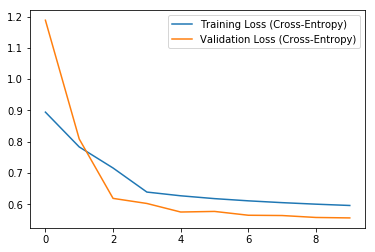

In [28]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

# Hyperparameter optimization